In [92]:
import mne
import matplotlib.pyplot as plt
import numpy as np
from performRPCA import rpca
from performFilter import performFilter
#from performEOGRegression import performEOGRegression
from prep.prep_pipeline import prep_pipeline


""" preprocess
    Performs all the preprocessing algorithims on the EEG data
    
    Parameters
    ----------
    eeg : mne raw object
        First Parameter, EEG Data (must include)
    params: dict
        dictionary of all the parameters 
        params = {'line_noise' : 50 \
                'filter_type': None, \
                'filt_freq': None, \
                'filter_length': 'auto', \
                'eog_index': -1, \
                'lam': -1,
                'tol': 1e-7,
                'max_iter': 1000
                }
        values included are default 
    
    Returns
    -------
    Data : double numpy array
        Corrected Data
    fig : matlib figures
        Figures of the data at different processing stages        
    
"""

def preprocess(eeg, params):
    eeg.load_data()
    #performPrep
    badChannels = ['Fc1.'] #prep_pipeline(eeg,params)
    eeg.info['bads'] = badChannels
    index = np.zeros(len(badChannels))
    index = index.astype(int) 
    

    
    #perfom filter
    eeg_filt = eeg.copy()
    eeg_filt._data = performFilter(eeg_filt.get_data(), eeg.info['sfreq'],\
                             params['filter_type'], \
                             params['filt_freq'],\
                             params['filter_length'])
    
    #eog_regression
    eeg_filt_eog = eeg_filt.copy()
    #eeg_filt_eog = performEOGRegression(raw_filt)
    
    #perform RPCA
    eeg_filt_eog_rpca = eeg_filt_eog.copy()
    eeg_filt_eog_rpca._data, noise = rpca(eeg_filt_eog.get_data(), \
                                    params['lam'], \
                                    params['tol'], \
                                    params['max_iter'])
    
    #Figures 
    
    fig1 = plt.figure(1,frameon=False)
    plt.setp(fig1,facecolor=[1,1,1], figwidth=15, figheight=50)
    ax = fig1.add_subplot(8, 1, 1)
    #EOG Graph
    if 'eog' in eeg:
        data = eeg.get_data()
        scale_min = np.min(np.min(data))
        scale_max = np.max(np.max(data))
        data = data - ((scale_max + scale_min)/2)
        plt.imshow(data,aspect='auto',extent=[0,(data.shape[1]/eeg.info['sfreq']),63,0],cmap=plt.get_cmap('coolwarm'))
        #plt.clim(scale_min,scale_max)
        plt.title('Filtered EOG data')
        plt.colorbar()
    else:
        plt.title('No EOG data available')
        params['eog_index'] = -1
    
    #EEG Filtered Plot
    ax = fig1.add_subplot(8, 1, 2)
    data = eeg_filt.get_data()
    scale_min = np.min(np.min(data))
    scale_max = np.max(np.max(data))
    data = data - ((scale_max + scale_min)/2)
    plt.imshow(data,aspect='auto',extent=[0,(data.shape[1]/eeg.info['sfreq']),63,0],cmap=plt.get_cmap('coolwarm'))
    #plt.clim(scale_min,scale_max)
    plt.colorbar()
    plt.title('Filtered EEG data')

    #EEG Filtered Plot Without Bad Channels
    allchan = raw.info['ch_names']
    ax = fig1.add_subplot(8, 1, 3)
    #delete this next line (index) when performPrep is fully functional
    index = np.array([3,4,12,13,14,15,16,17,18,19,20,21,23,30,31,32,37,38,39,40,41,42,44,45,46,47,48,49,61,63,64])
    data = eeg_filt.get_data()
    scale_min = np.min(np.min(data))
    scale_max = np.max(np.max(data))
  
    for i in range(len(index)): #len(badChannels)
        #index[i] = allchan.index(badChannels[i])
        data[(index[i]-1),:] = scale_min * np.ones((eeg._data.shape[1]))
    data = data - ((scale_max + scale_min)/2)
    plt.imshow(data,aspect='auto',extent=[0,(data.shape[1]/eeg.info['sfreq']),63,0],cmap=plt.get_cmap('coolwarm'))
    #plt.clim(scale_min,scale_max)
    plt.title('Detected bad channels')
    plt.colorbar()
    
    
    # Plot with EOG regression
    ax = fig1.add_subplot(8, 1, 4)
    
    if params['eog_index'] >=0:
        data = eeg_filt_eog.get_data()
        data = np.delete(data, index,0)
        scale_min = np.min(np.min(data))
        scale_max = np.max(np.max(data))
        data = data - ((scale_max + scale_min)/2)
        plt.imshow(data,aspect='auto',extent=[0,(data.shape[1]/eeg.info['sfreq']),63,0],cmap=plt.get_cmap('coolwarm'))
        #plt.clim(scale_min,scale_max)
        plt.colorbar()
        plt.title('EOG regressed out')
    else:
        plt.title('No EOG-Regression requested')
    
    #RPCA Corrected Data Plot
    ax = fig1.add_subplot(8, 1, 5)
    data = eeg_filt_eog_rpca.get_data()
    data = np.delete(data,index,0)
    rows = data.shape[0]
    scale_min = np.min(np.min(data))
    scale_max = np.max(np.max(data))
    data = data - ((scale_max + scale_min)/2)
    plt.imshow(data,aspect='auto',extent=[0,(data.shape[1]/eeg.info['sfreq']),rows,0],cmap=plt.get_cmap('coolwarm'))
    #plt.clim(scale_min,scale_max)
    plt.colorbar()
    plt.title('RPCA Corrected EEG data')
    
    #RPCA Noisy Data Plot
    ax = fig1.add_subplot(8, 1, 6)
    noise = np.delete(noise, index,0)
    scale_min = np.min(np.min(noise))
    scale_max = np.max(np.max(noise))
    noise = noise - ((scale_max + scale_min)/2)
    plt.imshow(noise,aspect='auto',extent=[0,(data.shape[1]/eeg.info['sfreq']),rows,0],cmap=plt.get_cmap('coolwarm'))
    #plt.clim(scale_min,scale_max)
    plt.colorbar()
    plt.title('Noise')
    
    eeg_clean = eeg_filt_eog_rpca.copy()
    
    fig2 = plt.figure(2)
    plt.setp(fig2,facecolor=[1,1,1], figwidth=15)
    data2 = eeg_clean.get_data()
    data2 = np.delete(data2, index,0)
    scale_min = np.min(np.min(data2))
    scale_max = np.max(np.max(data2))
    data2 = data2 - ((scale_max + scale_min)/2)
    plt.imshow(data2,aspect='auto',extent=[0,(data2.shape[1]/eeg.info['sfreq']),rows,0],cmap=plt.get_cmap('coolwarm'))
    #plt.clim(scale_min,scale_max)
    plt.colorbar()
    plt.title('Filtered EEG data') 
    
    
    eeg_clean = eeg_filt_eog_rpca.copy()
    eeg_clean._data = data2
    
    
    return eeg_clean,fig1,fig2
    

#### Tutorial of how to use the preprocess function in pyAutomagic

Preprocess is the wraper pipeline for preprocessing EEG data. It combines
prep_pipeline to locate bad channels, performFilter to help clean the
data, performEOGRegression to remove EOG artifact, and lastly RPCA will
remove any noisy components. After processing colorplots are made of the
data at each step in the pipeline. 

In [93]:
#First load a sample data set to work with using MNE. pyAutomagic uses
#mne raw object to store the data.
raw = mne.io.read_raw_edf('/Users/raphaelbechtold/Documents/MATLAB/Automagic/automagic/data/Subj1/S001R04.edf')

Extracting EDF parameters from /Users/raphaelbechtold/Documents/MATLAB/Automagic/automagic/data/Subj1/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [94]:
#Params is filled with the parameters for each processing function 
#Line noise usually 50 or 60
#'high', 'low', 'notch'
#filter frequency 
#Filter size, default='auto'
#True-use EOG regression False-exclude
#lamda - rpca parameter 
#Tolerence - rpca parameter 
#Maximum Iterations - rpca parameter 
params = {'line_noise' : 50,\
          'filter_type' : 'high', \
          'filt_freq' : None, \
          'filter_length' : 'auto', \
          'eog_index' : False, \
          'lam' : -1, \
          'tol' : 1e-7, \
          'max_iter': 1000 \
          }

Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 1057 samples (6.606 sec)



/Users/raphaelbechtold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:135: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/Users/raphaelbechtold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:147: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/Users/raphaelbechtold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:161: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


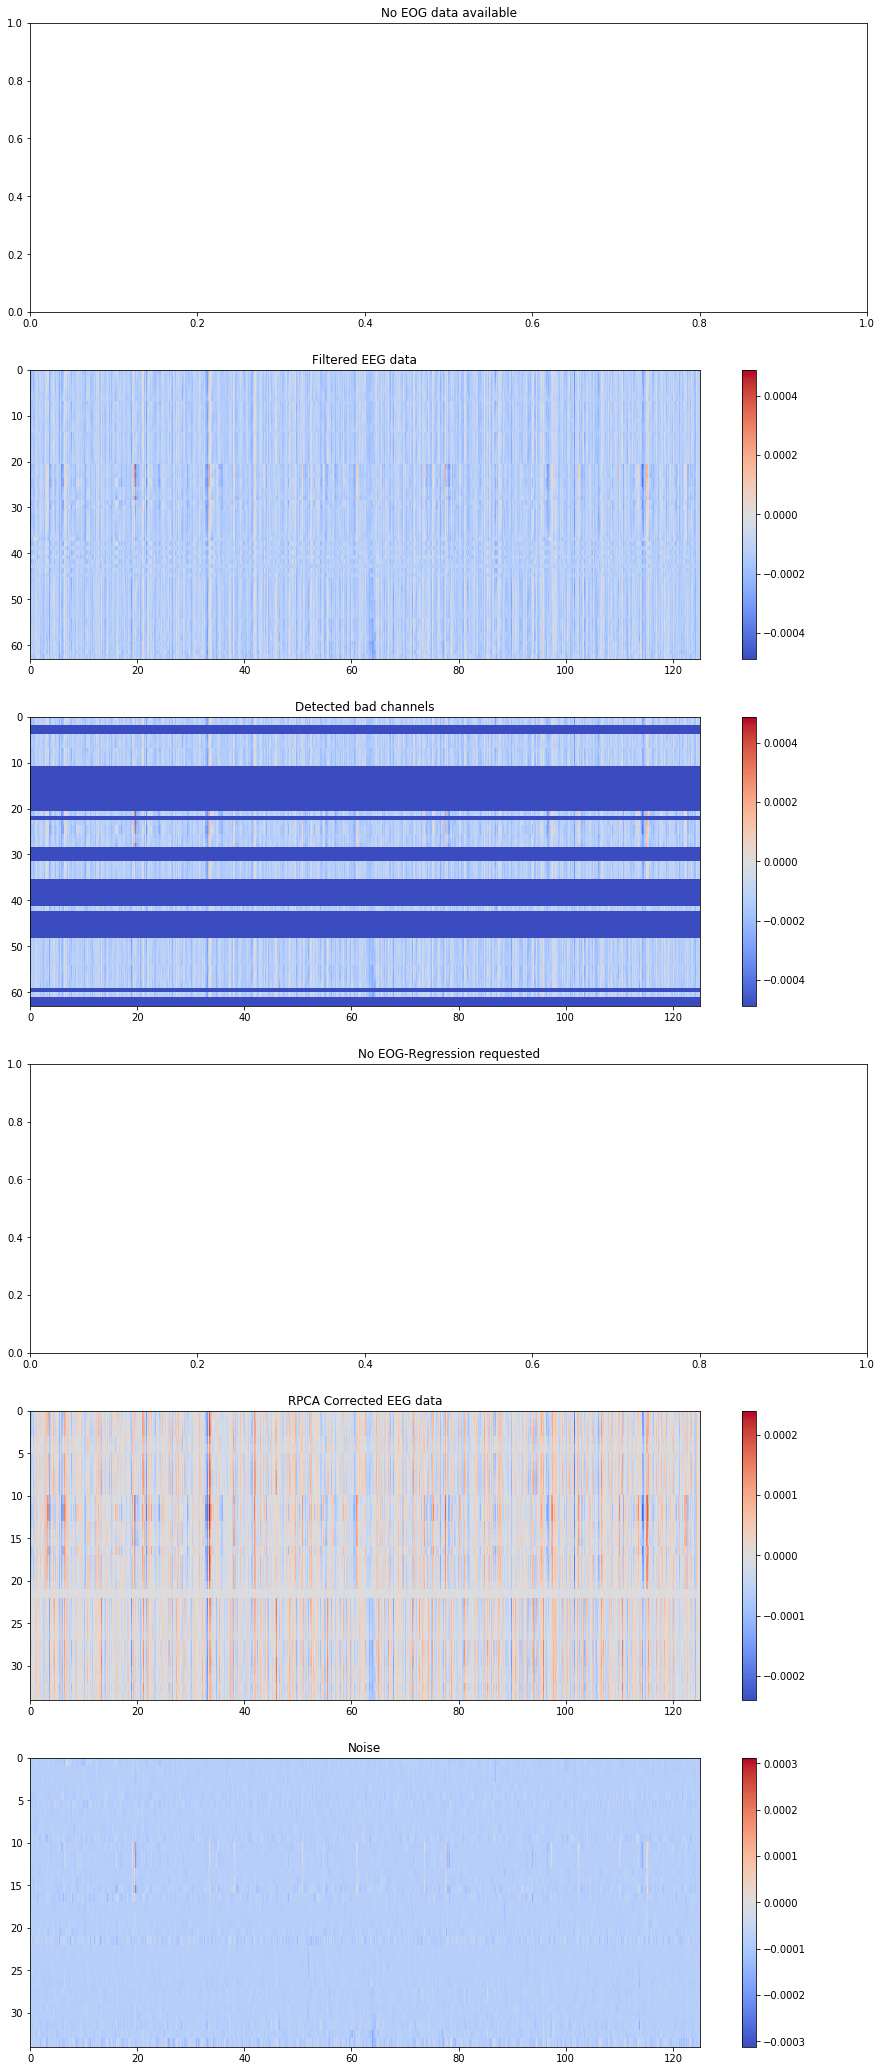

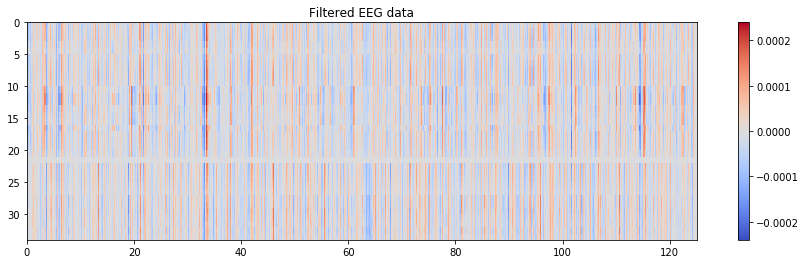

In [95]:
#Run the fuction to display plot
eeg_clean, fig1, fig2 = preprocess(raw, params)
#eeg_clean = final clean mne raw object
#fig1 = 6 Subplots: EOG, Initial Filtered EEG, 
#       marked bad channels, EEG with EOG removed,
#       RPCA Corrected, and RPCA removed noise 
#fig2 = single plot of the Initial Filtered EEG